# Directory check


In [16]:
import os

current_directory = os.getcwd()

absolute_path = os.path.abspath(os.path.join(current_directory,"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_outputscaling_beta_tests/softmax_fixed_beta/softmax_5"))

print(absolute_path)

c:\Users\Bernardo\Desktop\Work\data\CartPole-v1\jerbi\all_for_all\softmax\softmax_outputscaling_beta_tests\softmax_fixed_beta\softmax_5


# Analysis class and auxiliar functions

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def remove_leading_nones(nested_list):
    """
    Remove any sublist that starts with a None value from a nested list.

    Args:
        nested_list (list): A list of lists which may contain None values at the start.

    Returns:
        list: The modified list with sublists starting with None removed.
    """
    cleaned_list = []

    for sublist in nested_list:
        # Check if sublist is a list and does not start with None
        if isinstance(sublist, list) and (not sublist or sublist[0] is not None):
            # Recursively clean this sublist
            cleaned_sublist = remove_leading_nones(sublist)
            # Add the cleaned sublist to the result if it's not empty
            if cleaned_sublist:
                cleaned_list.append(cleaned_sublist)
        elif not isinstance(sublist, list):
            # If the item is not a list, add it directly
            cleaned_list.append(sublist)

    return cleaned_list

@staticmethod
def remove_repeated_gradients(grad_list):
    """
    Remove repeated gradients that were mistakenly saved multiple times per batch.

    Args:
        grad_list (list): A list of gradients where each gradient is repeated multiple times.

    Returns:
        list: A list with the repeated gradients removed.
    """
    cleaned_gradients = []
    seen_gradients = set()

    grad_list = remove_leading_nones(grad_list)
    for grad in grad_list:
        # Convert gradients to a tuple for hashable comparison
        grad_tuple = _convert_to_tuple(grad)
        if grad_tuple not in seen_gradients:
            seen_gradients.add(grad_tuple)
            cleaned_gradients.append(grad)

    return cleaned_gradients

@staticmethod
def _convert_to_tuple(grad):
    """
    Convert gradient arrays to a tuple for hashable comparison.
    """
    if isinstance(grad, np.ndarray):
        return tuple(grad.flatten())
    elif isinstance(grad, list):
        return tuple(_convert_to_tuple(g) for g in grad)
    else:
        return grad

In [14]:
class Analysis:
    def __init__(self, path_to_dir):
        self.path = path_to_dir
        separated_data = {
            'episode_reward': [],
            'loss': [],
            'runtime': [],
            'params_gradients': []
        }

        for subdir, dirs, files in os.walk(self.path):
            for file in files:
                if file.endswith('.npz'):
                    file_path = os.path.join(subdir, file)
                    if os.path.exists(file_path):
                        data = np.load(file_path, allow_pickle=True)
                        for key in separated_data:
                            if key in data:
                                separated_data[key].append(data[key].tolist())
        self.data = separated_data
        self.data['params_gradients'] = [remove_repeated_gradients(grad) for grad in self.data['params_gradients']]
        
    def get_rewards(self):
        return self.data["episode_reward"]

    def get_loss(self):
        return self.data["loss"]

    def get_runtime(self):
        return self.data["runtime"]

    def get_gradients(self):
        return self.data["params_gradients"]

    def get_moving_average(self, window_size=10):
        rewards = self.get_rewards()
        moving_averages = []
        for reward in rewards:
            moving_averages.append(pd.Series(reward).rolling(window_size).mean())
        return moving_averages

    def calculate_mean_variance_gradients(self, return_max=False, return_min=False):
        gradients = self.get_gradients()
        # Ensure all gradients have the same length
        min_length = min(len(grad) for grad in gradients)
        gradients = [grad[:min_length] for grad in gradients]
        
        # List to hold all magnitudes for each episode
        all_magnitudes = []

        for agent in gradients:
            agent_grad_norms = []
            for episode in agent:
                episode_magnitudes = []
                for param in episode:
                    # Check if param is None or contains None values
                    if param is None or (isinstance(param, (list, np.ndarray)) and all(x is None for x in param)):
                        episode_magnitudes.append(0)  # or any default value or skip this param
                    else:
                        # Compute the magnitude of each parameter vector
                        magnitude = np.linalg.norm(param)
                        episode_magnitudes.append(magnitude)
                agent_grad_norms.append(episode_magnitudes)
            all_magnitudes.append(agent_grad_norms)

        magnitudes_array = np.array(all_magnitudes, dtype=object)

        num_episodes = len(gradients[0])
        gradients_per_ep = []
        for episode in range(num_episodes):
            aux = []
            for agent in magnitudes_array:
                aux.append(agent[episode])
            gradients_per_ep.append(aux)

        def flatten_and_compute_mean(arrays):
            # Convert dtype=object arrays to standard numpy arrays if needed
            flattened_arrays = []
            for array in arrays:
                if isinstance(array, np.ndarray) and array.dtype == object:
                    # Convert object array to a regular numpy array
                    array = np.array(array.tolist())
                flattened_arrays.append(np.array(array).flatten())

            # Stack flattened arrays
            stacked_arrays = np.stack(flattened_arrays, axis=0)
            
            # Compute the mean along the new axis
            mean_array = np.mean(stacked_arrays, axis=0)
            
            return mean_array

        def flatten_and_compute_variance(arrays):
            # Convert dtype=object arrays to standard numpy arrays if needed
            flattened_arrays = []
            for array in arrays:
                if isinstance(array, np.ndarray) and array.dtype == object:
                    # Convert object array to a regular numpy array
                    array = np.array(array.tolist())
                flattened_arrays.append(np.array(array).flatten())

            # Stack flattened arrays
            stacked_arrays = np.stack(flattened_arrays, axis=0)
            
            # Compute the variance along the new axis
            variance_array = np.var(stacked_arrays, axis=0)
            
            return variance_array

        # Compute mean gradients per episode
        mean_gradients_per_ep = []
        for episode in gradients_per_ep:
            mean_gradients = flatten_and_compute_mean(episode)
            mean_gradients_per_ep.append(mean_gradients)
        
        # Compute variance gradients per episode
        variance_gradients_per_ep = []
        for episode in gradients_per_ep:
            variance_gradients = flatten_and_compute_variance(episode)
            variance_gradients_per_ep.append(variance_gradients)

        def extract_elements(arrays):
            if not arrays:
                return []
            
            # Determine the number of elements in each array
            num_elements = len(arrays[0])
            
            # Initialize lists for each position
            position_lists = [[] for _ in range(num_elements)]
            
            # Populate the lists with elements from each position
            for array in arrays:
                if len(array) != num_elements:
                    raise ValueError("All arrays must have the same length")
                for i in range(num_elements):
                    position_lists[i].append(array[i])
            
            return position_lists

        # Extract mean and variance elements
        mean_gradients = extract_elements(mean_gradients_per_ep)
        variance_gradients = extract_elements(variance_gradients_per_ep)

        return mean_gradients, variance_gradients

# Graphs

## UQC 1-4 qubit

In [40]:
UQC_FullEnc_paths= [ "../../../../data/CartPole-v1/UQC/UQC_FullEnc_1qubits",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_2qubits",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_2qubits_no_entangle",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits_no_entangle"]

UQC_FullEnc_1qubits = Analysis(UQC_FullEnc_paths[0])
UQC_FullEnc_2qubits = Analysis(UQC_FullEnc_paths[1])
UQC_FullEnc_2qubits_no_entangle = Analysis(UQC_FullEnc_paths[2])
UQC_FullEnc_4qubits = Analysis(UQC_FullEnc_paths[3])
UQC_FullEnc_4qubits_no_entangle = Analysis(UQC_FullEnc_paths[4])

UQC_FullEnc_1qubits_rewards = UQC_FullEnc_1qubits.get_moving_average(window_size=5)
UQC_FullEnc_2qubits_rewards = UQC_FullEnc_2qubits.get_moving_average(window_size=5)
UQC_FullEnc_2qubits_no_entangle_rewards = UQC_FullEnc_2qubits_no_entangle.get_moving_average(window_size=5)
UQC_FullEnc_4qubits_rewards = UQC_FullEnc_4qubits.get_moving_average(window_size=5)
UQC_FullEnc_4qubits_no_entangle_rewards = UQC_FullEnc_4qubits_no_entangle.get_moving_average(window_size=5)

UQC_FullEnc_1qubits_rewards_mean = np.mean(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_mean = np.mean(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_2qubits_no_entangle_rewards_mean = np.mean(UQC_FullEnc_2qubits_no_entangle_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_mean = np.mean(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_4qubits_no_entangle_rewards_mean = np.mean(UQC_FullEnc_4qubits_no_entangle_rewards, axis=0)

UQC_FullEnc_1qubits_rewards_std = np.std(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_std = np.std(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_2qubits_no_entangle_rewards_std = np.std(UQC_FullEnc_2qubits_no_entangle_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_std = np.std(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_4qubits_no_entangle_std = np.std(UQC_FullEnc_4qubits_no_entangle_rewards, axis=0)


UQC_FullEnc_1qubits_norm_grads,             UQC_FullEnc_1qubits_variance_grads = UQC_FullEnc_1qubits.calculate_mean_variance_gradients()
UQC_FullEnc_2qubits_norm_grads,             UQC_FullEnc_2qubits_variance_grads = UQC_FullEnc_2qubits.calculate_mean_variance_gradients()
UQC_FullEnc_2qubits_no_entangle_norm_grads, UQC_FullEnc_2qubits_no_entangle_variance_grads = UQC_FullEnc_2qubits_no_entangle.calculate_mean_variance_gradients()
UQC_FullEnc_4qubits_norm_grads,             UQC_FullEnc_4qubits_variance_grads = UQC_FullEnc_4qubits.calculate_mean_variance_gradients()
UQC_FullEnc_4qubits_no_entangle_norm_grads, UQC_FullEnc_4qubits_no_entangle_variance_grads = UQC_FullEnc_4qubits_no_entangle.calculate_mean_variance_gradients()


UQC_FullEnc_1qubits_runtime = sum(map(sum, UQC_FullEnc_1qubits.get_runtime())) / len(UQC_FullEnc_1qubits.get_runtime())/60
UQC_FullEnc_2qubits_runtime = sum(map(sum, UQC_FullEnc_2qubits.get_runtime())) / len(UQC_FullEnc_2qubits.get_runtime())/60
UQC_FullEnc_2qubits_no_entangle_runtime = sum(map(sum, UQC_FullEnc_2qubits_no_entangle.get_runtime())) / len(UQC_FullEnc_2qubits_no_entangle.get_runtime())/60
UQC_FullEnc_4qubits_runtime = sum(map(sum, UQC_FullEnc_4qubits.get_runtime())) / len(UQC_FullEnc_4qubits.get_runtime())/60
UQC_FullEnc_4qubits_no_entangle_runtime = sum(map(sum, UQC_FullEnc_4qubits_no_entangle.get_runtime())) / len(UQC_FullEnc_4qubits_no_entangle.get_runtime())/60




UQC_PartialEnc_paths= ["../../../../data/CartPole-v1/UQC/UQC_PartialEnc_2qubits",
                        "../../../../data/CartPole-v1/UQC/UQC_PartialEnc_2qubits_no_entangle",
                        "../../../../data/CartPole-v1/UQC/UQC_PartialEnc_4qubits",
                        "../../../../data/CartPole-v1/UQC/UQC_PartialEnc_4qubits_no_entangle"]

UQC_PartialEnc_2qubits = Analysis(UQC_PartialEnc_paths[0])
UQC_PartialEnc_2qubits_no_entangle = Analysis(UQC_PartialEnc_paths[1])
UQC_PartialEnc_4qubits = Analysis(UQC_PartialEnc_paths[2])
UQC_PartialEnc_4qubits_no_entangle = Analysis(UQC_PartialEnc_paths[3])

UQC_PartialEnc_2qubits_rewards = UQC_PartialEnc_2qubits.get_moving_average(window_size=5)
UQC_PartialEnc_2qubits_no_entangle_rewards = UQC_PartialEnc_2qubits_no_entangle.get_moving_average(window_size=5)
UQC_PartialEnc_4qubits_rewards = UQC_PartialEnc_4qubits.get_moving_average(window_size=5)
UQC_PartialEnc_4qubits_no_entangle_rewards = UQC_PartialEnc_4qubits_no_entangle.get_moving_average(window_size=5)

UQC_PartialEnc_2qubits_rewards_mean = np.mean(UQC_PartialEnc_2qubits_rewards, axis=0)
UQC_PartialEnc_2qubits_no_entangle_rewards_mean = np.mean(UQC_PartialEnc_2qubits_no_entangle_rewards, axis=0)
UQC_PartialEnc_4qubits_rewards_mean = np.mean(UQC_PartialEnc_4qubits_rewards, axis=0)
UQC_PartialEnc_4qubits_no_entangle_rewards_mean = np.mean(UQC_PartialEnc_4qubits_no_entangle_rewards, axis=0)

UQC_PartialEnc_2qubits_rewards_std = np.std(UQC_PartialEnc_2qubits_rewards, axis=0)
UQC_PartialEnc_2qubits_no_entangle_rewards_std = np.std(UQC_PartialEnc_2qubits_no_entangle_rewards, axis=0)
UQC_PartialEnc_4qubits_rewards_std = np.std(UQC_PartialEnc_4qubits_rewards, axis=0)
UQC_PartialEnc_4qubits_no_entangle_std = np.std(UQC_PartialEnc_4qubits_no_entangle_rewards, axis=0)

UQC_PartialEnc_2qubits_norm_grads,             UQC_PartialEnc_2qubits_variance_grads = UQC_PartialEnc_2qubits.calculate_mean_variance_gradients()
UQC_PartialEnc_2qubits_no_entangle_norm_grads, UQC_PartialEnc_2qubits_no_entangle_variance_grads = UQC_PartialEnc_2qubits_no_entangle.calculate_mean_variance_gradients()
UQC_PartialEnc_4qubits_norm_grads,             UQC_PartialEnc_4qubits_variance_grads = UQC_PartialEnc_4qubits.calculate_mean_variance_gradients()
UQC_PartialEnc_4qubits_no_entangle_norm_grads, UQC_PartialEnc_4qubits_no_entangle_variance_grads = UQC_PartialEnc_4qubits_no_entangle.calculate_mean_variance_gradients()

UQC_PartialEnc_2qubits_runtime = sum(map(sum, UQC_PartialEnc_2qubits.get_runtime())) / len(UQC_PartialEnc_2qubits.get_runtime())/60
UQC_PartialEnc_2qubits_no_entangle_runtime = sum(map(sum, UQC_PartialEnc_2qubits_no_entangle.get_runtime())) / len(UQC_PartialEnc_2qubits_no_entangle.get_runtime())/60
UQC_PartialEnc_4qubits_runtime = sum(map(sum, UQC_PartialEnc_4qubits.get_runtime())) / len(UQC_PartialEnc_4qubits.get_runtime())/60
UQC_PartialEnc_4qubits_no_entangle_runtime = sum(map(sum, UQC_PartialEnc_4qubits_no_entangle.get_runtime())) / len(UQC_PartialEnc_4qubits_no_entangle.get_runtime())/60

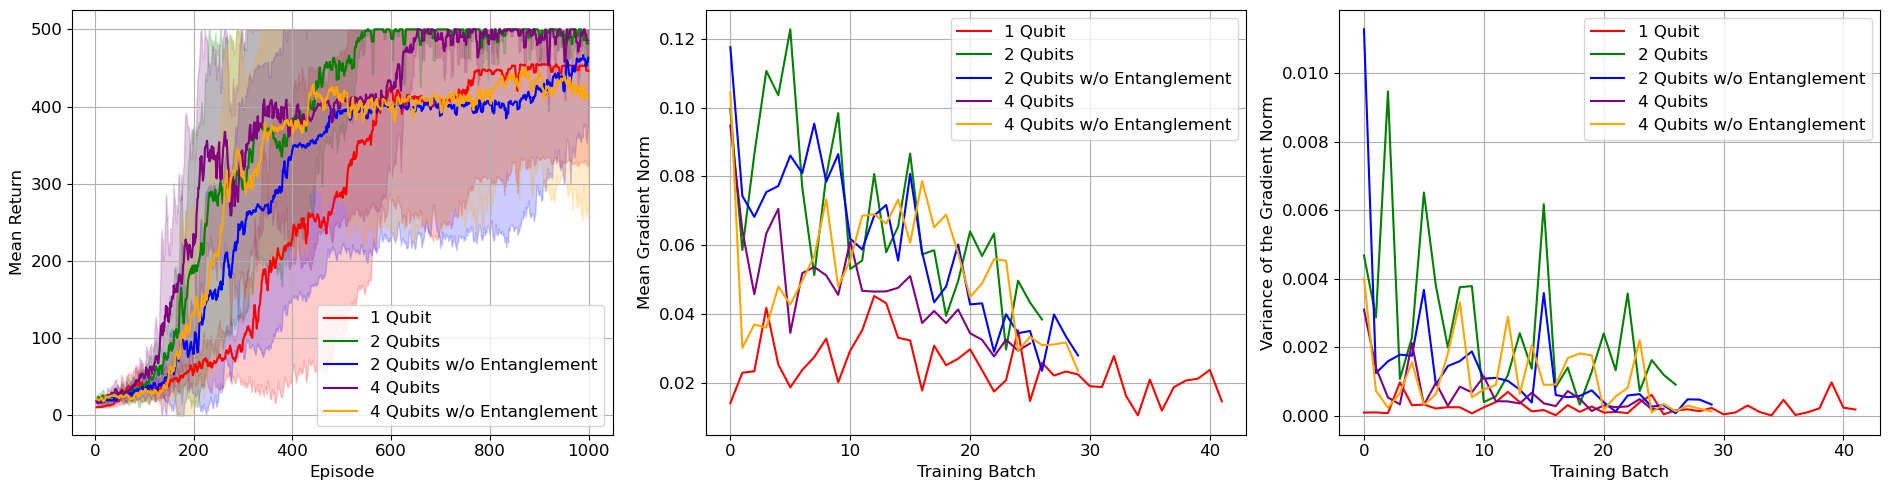

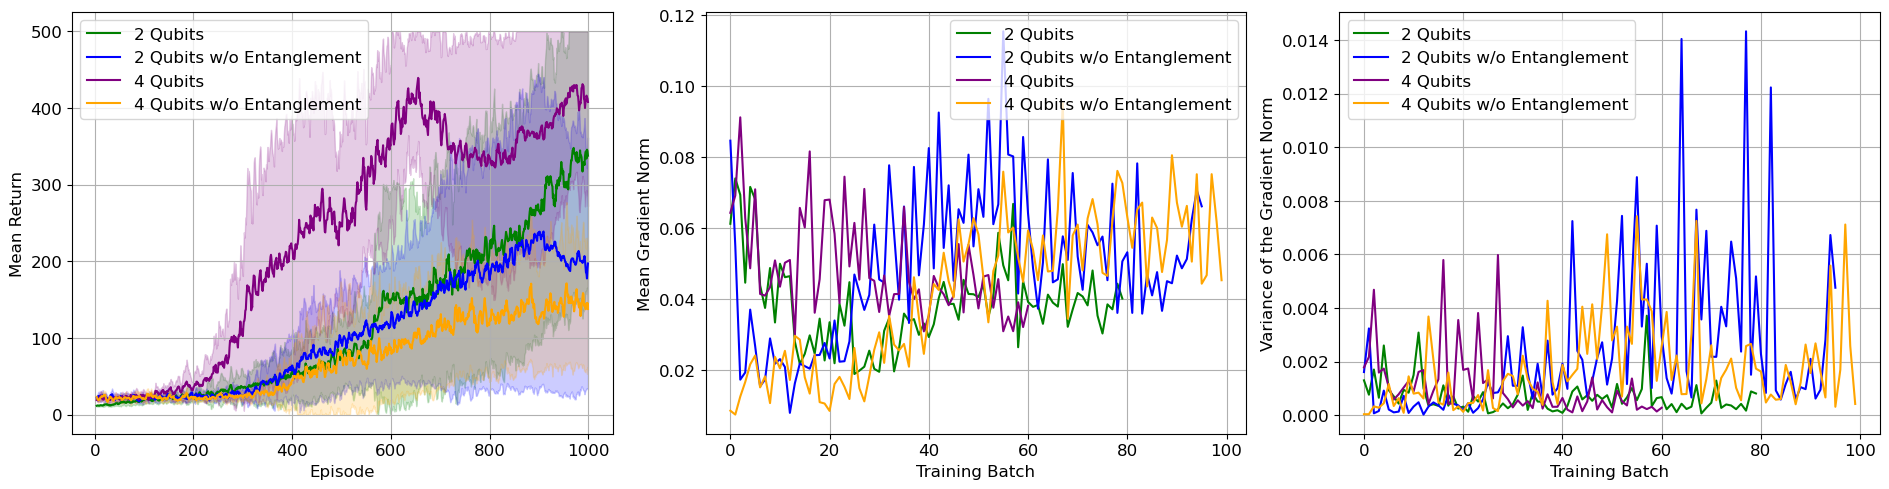

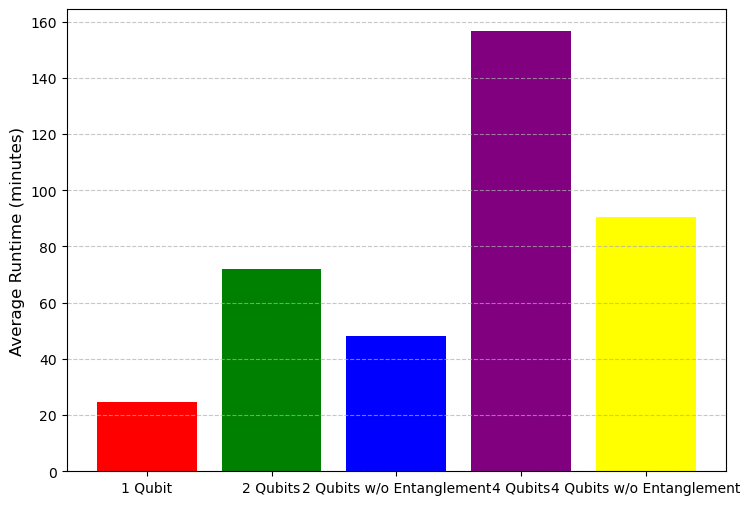

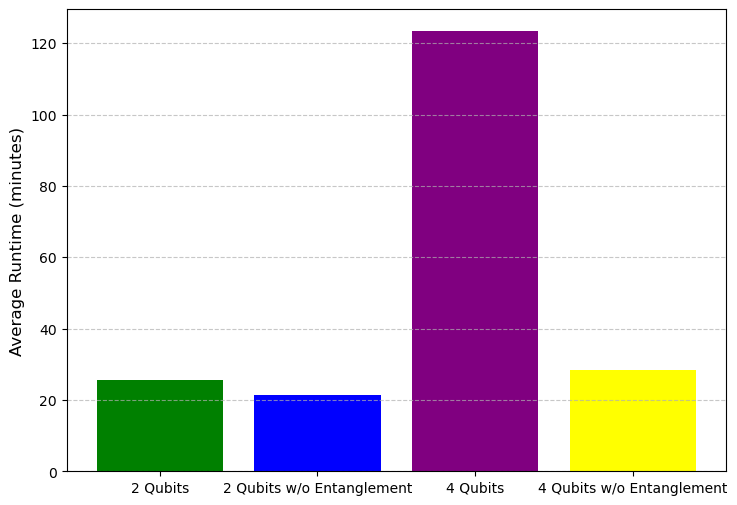

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5), tight_layout=True)

# Plot first set of data
axs[0].plot(UQC_FullEnc_1qubits_rewards_mean, color="red", label="1 Qubit")
axs[0].plot(UQC_FullEnc_2qubits_rewards_mean, color="green", label="2 Qubits")
axs[0].plot(UQC_FullEnc_2qubits_no_entangle_rewards_mean, color="blue", label="2 Qubits w/o Entanglement")
axs[0].plot(UQC_FullEnc_4qubits_rewards_mean, color="purple", label="4 Qubits")
axs[0].plot(UQC_FullEnc_4qubits_no_entangle_rewards_mean, color="orange", label="4 Qubits w/o Entanglement")
axs[0].fill_between(np.arange(len(UQC_FullEnc_1qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_1qubits_rewards_mean - UQC_FullEnc_1qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_1qubits_rewards_mean + UQC_FullEnc_1qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(UQC_FullEnc_2qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_2qubits_rewards_mean - UQC_FullEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_2qubits_rewards_mean + UQC_FullEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(UQC_FullEnc_2qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_FullEnc_2qubits_no_entangle_rewards_mean - UQC_FullEnc_2qubits_no_entangle_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_2qubits_no_entangle_rewards_mean + UQC_FullEnc_2qubits_no_entangle_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="blue")
axs[0].fill_between(np.arange(len(UQC_FullEnc_4qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_4qubits_rewards_mean - UQC_FullEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_4qubits_rewards_mean + UQC_FullEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="purple")
axs[0].fill_between(np.arange(len(UQC_FullEnc_4qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_FullEnc_4qubits_no_entangle_rewards_mean - UQC_FullEnc_4qubits_no_entangle_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_4qubits_no_entangle_rewards_mean + UQC_FullEnc_4qubits_no_entangle_std, a_min=0, a_max=500),
                    alpha=0.2, color="orange")
axs[0].set_xlabel("Episode", fontsize=12)
axs[0].set_ylabel("Mean Return", fontsize=12)
axs[0].legend(fontsize=12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot smoothed mean gradient norm
axs[1].plot(UQC_FullEnc_1qubits_norm_grads[1], color="red", label="1 Qubit")
axs[1].plot(UQC_FullEnc_2qubits_norm_grads[1], color="green", label="2 Qubits")
axs[1].plot(UQC_FullEnc_2qubits_no_entangle_norm_grads[1], color="blue", label="2 Qubits w/o Entanglement")
axs[1].plot(UQC_FullEnc_4qubits_norm_grads[1], color="purple", label="4 Qubits")
axs[1].plot(UQC_FullEnc_4qubits_no_entangle_norm_grads[1], color="orange", label="4 Qubits w/o Entanglement")
axs[1].set_xlabel("Training Batch", fontsize=12)
axs[1].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

# Plot smoothed variance of gradient norm
axs[2].plot(UQC_FullEnc_1qubits_variance_grads[1], color="red", label="1 Qubit")
axs[2].plot(UQC_FullEnc_2qubits_variance_grads[1], color="green", label="2 Qubits")
axs[2].plot(UQC_FullEnc_2qubits_no_entangle_variance_grads[1], color="blue", label="2 Qubits w/o Entanglement")
axs[2].plot(UQC_FullEnc_4qubits_variance_grads[1], color="purple", label="4 Qubits")
axs[2].plot(UQC_FullEnc_4qubits_no_entangle_variance_grads[1], color="orange", label="4 Qubits w/o Entanglement")
axs[2].set_xlabel("Training Batch", fontsize=12)
axs[2].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[2].legend(fontsize=12)
axs[2].xaxis.set_tick_params(labelsize=12)
axs[2].yaxis.set_tick_params(labelsize=12)
axs[2].grid(True)

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(19, 5), tight_layout=True)

# Plot first set of data
axs[0].plot(UQC_PartialEnc_2qubits_rewards_mean, color="green", label="2 Qubits")
axs[0].plot(UQC_PartialEnc_2qubits_no_entangle_rewards_mean, color="blue", label="2 Qubits w/o Entanglement")
axs[0].plot(UQC_PartialEnc_4qubits_rewards_mean, color="purple", label="4 Qubits")
axs[0].plot(UQC_PartialEnc_4qubits_no_entangle_rewards_mean, color="orange", label="4 Qubits w/o Entanglement")
axs[0].fill_between(np.arange(len(UQC_PartialEnc_2qubits_rewards_mean)), 
                    np.clip(UQC_PartialEnc_2qubits_rewards_mean - UQC_PartialEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_PartialEnc_2qubits_rewards_mean + UQC_PartialEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(UQC_PartialEnc_2qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_PartialEnc_2qubits_no_entangle_rewards_mean - UQC_PartialEnc_2qubits_no_entangle_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_PartialEnc_2qubits_no_entangle_rewards_mean + UQC_PartialEnc_2qubits_no_entangle_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="blue")
axs[0].fill_between(np.arange(len(UQC_PartialEnc_4qubits_rewards_mean)), 
                    np.clip(UQC_PartialEnc_4qubits_rewards_mean - UQC_PartialEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_PartialEnc_4qubits_rewards_mean + UQC_PartialEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="purple")
axs[0].fill_between(np.arange(len(UQC_PartialEnc_4qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_PartialEnc_4qubits_no_entangle_rewards_mean - UQC_PartialEnc_4qubits_no_entangle_std, a_min=0, a_max=500),
                    np.clip(UQC_PartialEnc_4qubits_no_entangle_rewards_mean + UQC_PartialEnc_4qubits_no_entangle_std, a_min=0, a_max=500),
                    alpha=0.2, color="orange")
axs[0].set_xlabel("Episode", fontsize=12)
axs[0].set_ylabel("Mean Return", fontsize=12)
axs[0].legend(fontsize=12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot smoothed mean gradient norm
axs[1].plot(UQC_PartialEnc_2qubits_norm_grads[1], color="green", label="2 Qubits")
axs[1].plot(UQC_PartialEnc_2qubits_no_entangle_norm_grads[1], color="blue", label="2 Qubits w/o Entanglement")
axs[1].plot(UQC_PartialEnc_4qubits_norm_grads[1], color="purple", label="4 Qubits")
axs[1].plot(UQC_PartialEnc_4qubits_no_entangle_norm_grads[1], color="orange", label="4 Qubits w/o Entanglement")
axs[1].set_xlabel("Training Batch", fontsize=12)
axs[1].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

# Plot smoothed variance of gradient norm
axs[2].plot(UQC_PartialEnc_2qubits_variance_grads[1], color="green", label="2 Qubits")
axs[2].plot(UQC_PartialEnc_2qubits_no_entangle_variance_grads[1], color="blue", label="2 Qubits w/o Entanglement")
axs[2].plot(UQC_PartialEnc_4qubits_variance_grads[1], color="purple", label="4 Qubits")
axs[2].plot(UQC_PartialEnc_4qubits_no_entangle_variance_grads[1], color="orange", label="4 Qubits w/o Entanglement")
axs[2].set_xlabel("Training Batch", fontsize=12)
axs[2].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[2].legend(fontsize=12)
axs[2].xaxis.set_tick_params(labelsize=12)
axs[2].yaxis.set_tick_params(labelsize=12)
axs[2].grid(True)

plt.show()

plt.figure(figsize=(8.5, 6))
plt.bar(["1 Qubit","2 Qubits","2 Qubits w/o Entanglement","4 Qubits","4 Qubits w/o Entanglement"], 
        [UQC_FullEnc_1qubits_runtime,UQC_FullEnc_2qubits_runtime,UQC_FullEnc_2qubits_no_entangle_runtime,UQC_FullEnc_4qubits_runtime,UQC_FullEnc_4qubits_no_entangle_runtime]
        , color=['red', 'green', 'blue', 'purple', 'yellow'])

# Add titles and labels
plt.ylabel("Average Runtime (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

plt.figure(figsize=(8.5, 6))
plt.bar(["2 Qubits","2 Qubits w/o Entanglement","4 Qubits","4 Qubits w/o Entanglement"], 
        [UQC_PartialEnc_2qubits_runtime,UQC_PartialEnc_2qubits_no_entangle_runtime,UQC_PartialEnc_4qubits_runtime,UQC_PartialEnc_4qubits_no_entangle_runtime]
        , color=[ 'green', 'blue', 'purple', 'yellow'])

# Add titles and labels
plt.ylabel("Average Runtime (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

## UQC Raw vs Softmax

In [11]:
uqc_policies_paths = [
    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_2qubits_raw_contiguous",
    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_2qubits_raw_parity",
    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_2qubits"
]

# Initialize Analysis objects
uqc_model_raw_contiguous = Analysis(uqc_policies_paths[0])
uqc_model_raw_parity = Analysis(uqc_policies_paths[1])
uqc_model = Analysis(uqc_policies_paths[2])

# Calculate moving averages for rewards
uqc_model_raw_contiguous_rewards = uqc_model_raw_contiguous.get_moving_average(window_size=5)
uqc_model_raw_parity_rewards = uqc_model_raw_parity.get_moving_average(window_size=5)
uqc_model_rewards = uqc_model.get_moving_average(window_size=5)

# Compute mean and std for rewards
uqc_model_raw_contiguous_rewards_mean = np.mean(uqc_model_raw_contiguous_rewards, axis=0)
uqc_model_raw_parity_rewards_mean = np.mean(uqc_model_raw_parity_rewards, axis=0)
uqc_model_rewards_mean = np.mean(uqc_model_rewards, axis=0)

uqc_model_raw_contiguous_rewards_std = np.std(uqc_model_raw_contiguous_rewards, axis=0)
uqc_model_raw_parity_rewards_std = np.std(uqc_model_raw_parity_rewards, axis=0)
uqc_model_rewards_std = np.std(uqc_model_rewards, axis=0)

# Calculate gradients and their variance
uqc_model_raw_contiguous_norm_grads, uqc_model_raw_contiguous_variance_grads = uqc_model_raw_contiguous.calculate_mean_variance_gradients()
uqc_model_raw_parity_norm_grads, uqc_model_raw_parity_variance_grads = uqc_model_raw_parity.calculate_mean_variance_gradients()
uqc_model_norm_grads, uqc_model_variance_grads = uqc_model.calculate_mean_variance_gradients()

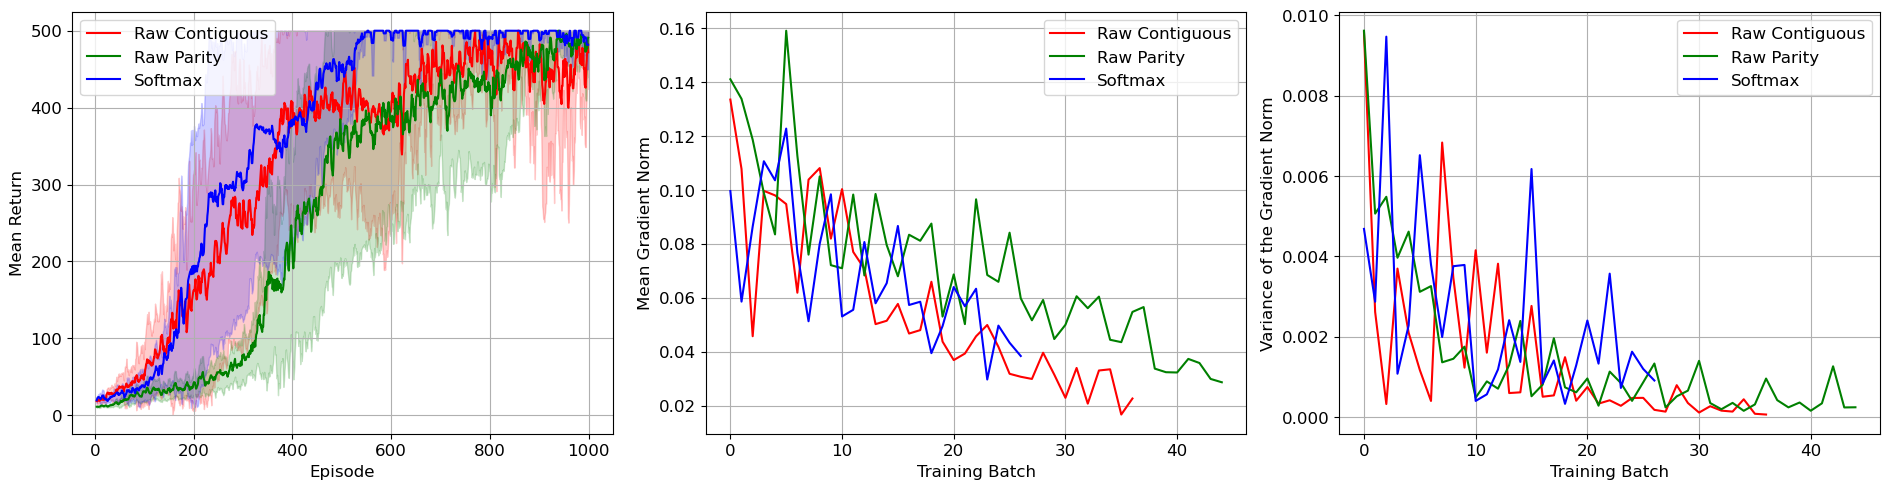

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5), tight_layout=True)

# Plot first set of data
axs[0].plot(uqc_model_raw_contiguous_rewards_mean, color="red", label="Raw Contiguous")
axs[0].plot(uqc_model_raw_parity_rewards_mean, color="green", label="Raw Parity")
axs[0].plot(uqc_model_rewards_mean, color="blue", label="Softmax")
axs[0].fill_between(np.arange(len(uqc_model_raw_contiguous_rewards_mean)), 
                    np.clip(uqc_model_raw_contiguous_rewards_mean - uqc_model_raw_contiguous_rewards_std, a_min=0, a_max=500),
                    np.clip(uqc_model_raw_contiguous_rewards_mean + uqc_model_raw_contiguous_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(uqc_model_raw_parity_rewards_mean)), 
                    np.clip(uqc_model_raw_parity_rewards_mean - uqc_model_raw_parity_rewards_std, a_min=0, a_max=500),
                    np.clip(uqc_model_raw_parity_rewards_mean + uqc_model_raw_parity_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(uqc_model_rewards_mean)), 
                    np.clip(uqc_model_rewards_mean - uqc_model_rewards_std, a_min=0, a_max=500),
                    np.clip(uqc_model_rewards_mean + uqc_model_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="blue")
axs[0].set_xlabel("Episode", fontsize=12)
axs[0].set_ylabel("Mean Return", fontsize=12)
axs[0].legend(fontsize=12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot smoothed mean gradient norm
axs[1].plot(uqc_model_raw_contiguous_norm_grads[1], color="red", label="Raw Contiguous")
axs[1].plot(uqc_model_raw_parity_norm_grads[1], color="green", label="Raw Parity")
axs[1].plot(uqc_model_norm_grads[1], color="blue", label="Softmax")
axs[1].set_xlabel("Training Batch", fontsize=12)
axs[1].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

# Plot smoothed variance of gradient norm
axs[2].plot(uqc_model_raw_contiguous_variance_grads[1], color="red", label="Raw Contiguous")
axs[2].plot(uqc_model_raw_parity_variance_grads[1], color="green", label="Raw Parity")
axs[2].plot(uqc_model_variance_grads[1], color="blue", label="Softmax")
axs[2].set_xlabel("Training Batch", fontsize=12)
axs[2].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[2].legend(fontsize=12)
axs[2].xaxis.set_tick_params(labelsize=12)
axs[2].yaxis.set_tick_params(labelsize=12)
axs[2].grid(True)

plt.show()

## UQC Beta Schedule

In [17]:
uqc_beta_paths = [
    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_1qubits",
    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_1qubits_beta",
]

# Initialize Analysis objects
uqc_model_1qubit = Analysis(uqc_beta_paths[0])
uqc_model_1qubit_beta = Analysis(uqc_beta_paths[1])

# Calculate moving averages for rewards
uqc_model_1qubit_rewards = uqc_model_1qubit.get_moving_average(window_size=5)
uqc_model_1qubit_beta_rewards = uqc_model_1qubit_beta.get_moving_average(window_size=5)

# Compute mean and std for rewards
uqc_model_1qubit_rewards_mean = np.mean(uqc_model_1qubit_rewards, axis=0)
uqc_model_1qubit_beta_rewards_mean = np.mean(uqc_model_1qubit_beta_rewards, axis=0)

uqc_model_1qubit_rewards_std = np.std(uqc_model_1qubit_rewards, axis=0)
uqc_model_1qubit_beta_rewards_std = np.std(uqc_model_1qubit_beta_rewards, axis=0)

# Calculate gradients and their variance
uqc_model_1qubit_norm_grads, uqc_model_1qubit_variance_grads = uqc_model_1qubit.calculate_mean_variance_gradients()
uqc_model_1qubit_beta_norm_grads, uqc_model_1qubit_beta_variance_grads = uqc_model_1qubit_beta.calculate_mean_variance_gradients()

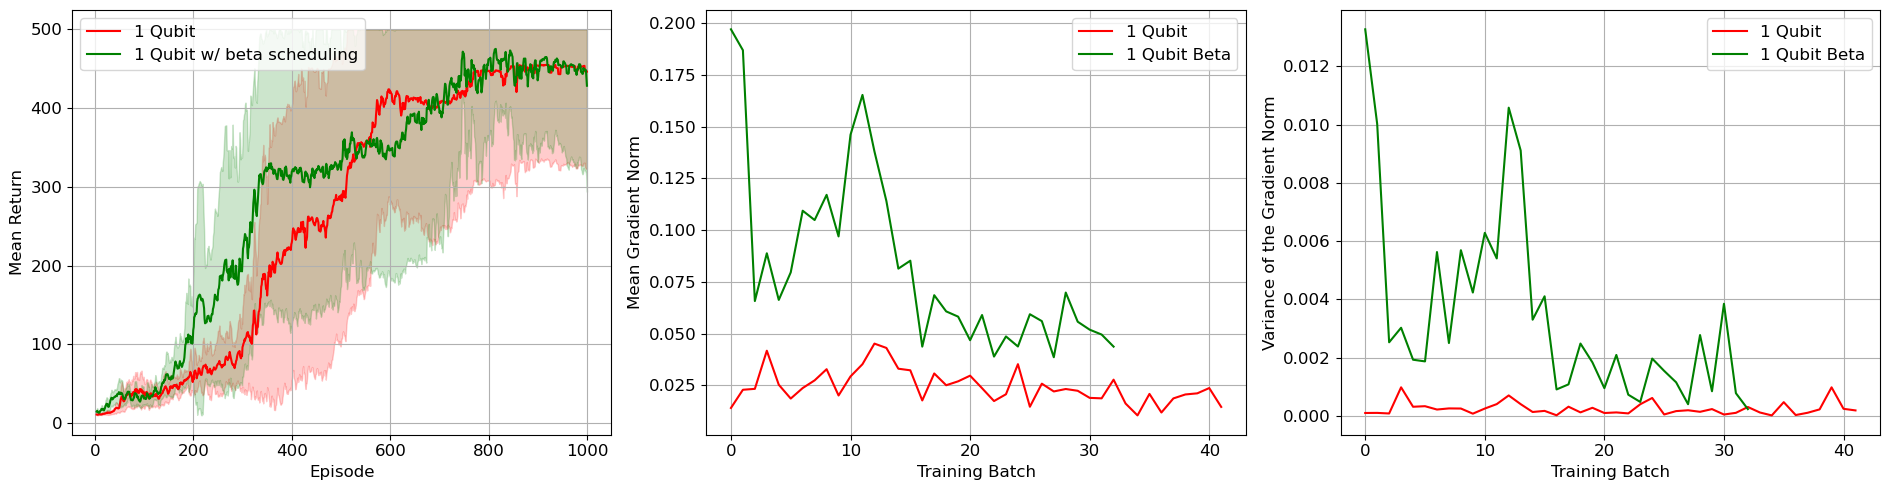

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5), tight_layout=True)

# Plot first set of data (Mean Return)
axs[0].plot(uqc_model_1qubit_rewards_mean, color="red", label="1 Qubit")
axs[0].plot(uqc_model_1qubit_beta_rewards_mean, color="green", label="1 Qubit w/ beta scheduling")
axs[0].fill_between(np.arange(len(uqc_model_1qubit_rewards_mean)), 
                    np.clip(uqc_model_1qubit_rewards_mean - uqc_model_1qubit_rewards_std, a_min=0, a_max=500),
                    np.clip(uqc_model_1qubit_rewards_mean + uqc_model_1qubit_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(uqc_model_1qubit_beta_rewards_mean)), 
                    np.clip(uqc_model_1qubit_beta_rewards_mean - uqc_model_1qubit_beta_rewards_std, a_min=0, a_max=500),
                    np.clip(uqc_model_1qubit_beta_rewards_mean + uqc_model_1qubit_beta_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
axs[0].set_xlabel("Episode", fontsize=12)
axs[0].set_ylabel("Mean Return", fontsize=12)
axs[0].legend(fontsize=12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot smoothed mean gradient norm
axs[1].plot(uqc_model_1qubit_norm_grads[1], color="red", label="1 Qubit")
axs[1].plot(uqc_model_1qubit_beta_norm_grads[1], color="green", label="1 Qubit Beta")
axs[1].set_xlabel("Training Batch", fontsize=12)
axs[1].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

# Plot smoothed variance of gradient norm
axs[2].plot(uqc_model_1qubit_variance_grads[1], color="red", label="1 Qubit")
axs[2].plot(uqc_model_1qubit_beta_variance_grads[1], color="green", label="1 Qubit Beta")
axs[2].set_xlabel("Training Batch", fontsize=12)
axs[2].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[2].legend(fontsize=12)
axs[2].xaxis.set_tick_params(labelsize=12)
axs[2].yaxis.set_tick_params(labelsize=12)
axs[2].grid(True)

plt.show()

## UQC Qubit scalling test

In [15]:
UQC_FullEnc_paths= [ "../../../../data/CartPole-v1/UQC/UQC_FullEnc_1qubits",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_2qubits",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_6qubits"]

UQC_FullEnc_1qubits = Analysis(UQC_FullEnc_paths[0])
UQC_FullEnc_2qubits = Analysis(UQC_FullEnc_paths[1])
UQC_FullEnc_4qubits = Analysis(UQC_FullEnc_paths[2])
UQC_FullEnc_6qubits = Analysis(UQC_FullEnc_paths[3])

UQC_FullEnc_1qubits_rewards = UQC_FullEnc_1qubits.get_moving_average(window_size=5)
UQC_FullEnc_2qubits_rewards = UQC_FullEnc_2qubits.get_moving_average(window_size=5)
UQC_FullEnc_4qubits_rewards = UQC_FullEnc_4qubits.get_moving_average(window_size=5)
UQC_FullEnc_6qubits_rewards = UQC_FullEnc_6qubits.get_moving_average(window_size=5)

UQC_FullEnc_1qubits_rewards_mean = np.mean(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_mean = np.mean(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_mean = np.mean(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_6qubits_rewards_mean = np.mean(UQC_FullEnc_6qubits_rewards, axis=0)

UQC_FullEnc_1qubits_rewards_std = np.std(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_std = np.std(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_std = np.std(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_6qubits_rewards_std = np.std(UQC_FullEnc_6qubits_rewards, axis=0)

UQC_FullEnc_1qubits_norm_grads, UQC_FullEnc_1qubits_variance_grads = UQC_FullEnc_1qubits.calculate_mean_variance_gradients()
UQC_FullEnc_2qubits_norm_grads, UQC_FullEnc_2qubits_variance_grads = UQC_FullEnc_2qubits.calculate_mean_variance_gradients()
UQC_FullEnc_4qubits_norm_grads, UQC_FullEnc_4qubits_variance_grads = UQC_FullEnc_4qubits.calculate_mean_variance_gradients()
UQC_FullEnc_6qubits_norm_grads, UQC_FullEnc_6qubits_variance_grads = UQC_FullEnc_6qubits.calculate_mean_variance_gradients()

UQC_FullEnc_1qubits_runtime = sum(map(sum, UQC_FullEnc_1qubits.get_runtime())) / len(UQC_FullEnc_1qubits.get_runtime()) / 60
UQC_FullEnc_2qubits_runtime = sum(map(sum, UQC_FullEnc_2qubits.get_runtime())) / len(UQC_FullEnc_2qubits.get_runtime()) / 60
UQC_FullEnc_4qubits_runtime = sum(map(sum, UQC_FullEnc_4qubits.get_runtime())) / len(UQC_FullEnc_4qubits.get_runtime()) / 60
UQC_FullEnc_6qubits_runtime = sum(map(sum, UQC_FullEnc_6qubits.get_runtime())) / len(UQC_FullEnc_6qubits.get_runtime()) / 60

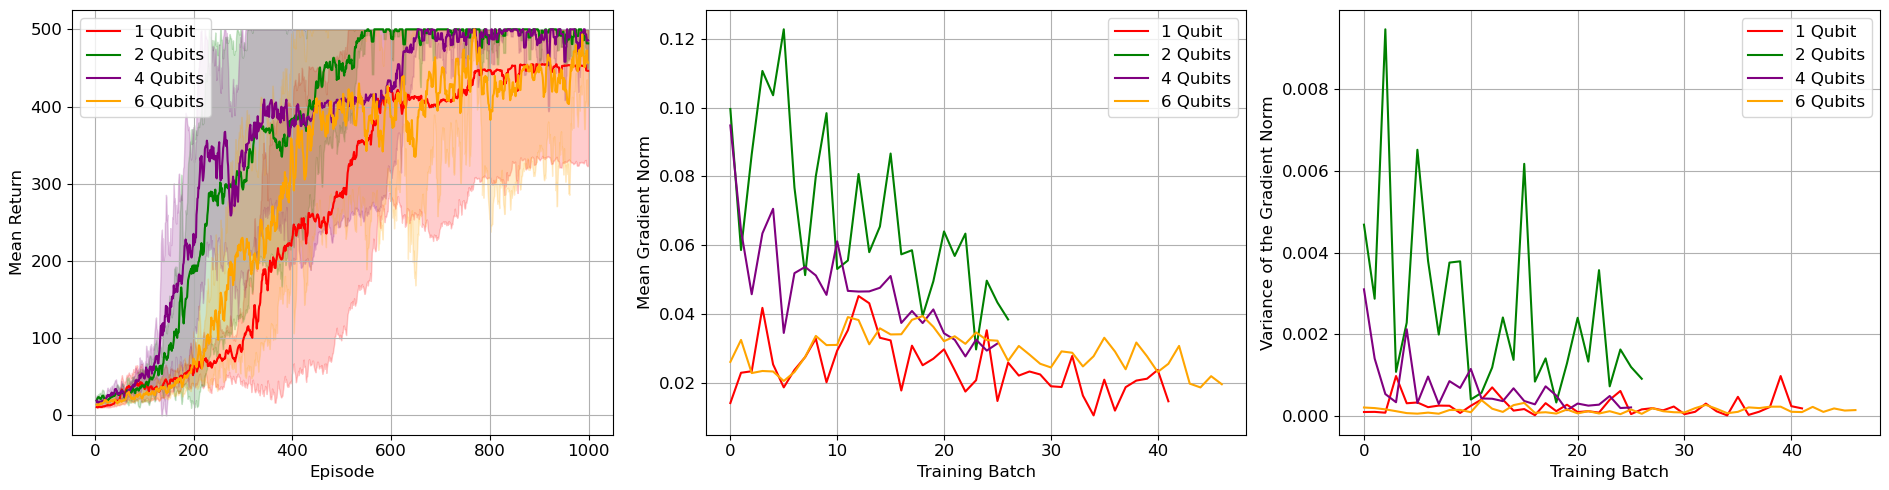

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5), tight_layout=True)

# Plot the rewards mean and standard deviation for each configuration
axs[0].plot(UQC_FullEnc_1qubits_rewards_mean, color="red", label="1 Qubit")
axs[0].plot(UQC_FullEnc_2qubits_rewards_mean, color="green", label="2 Qubits")
axs[0].plot(UQC_FullEnc_4qubits_rewards_mean, color="purple", label="4 Qubits")
axs[0].plot(UQC_FullEnc_6qubits_rewards_mean, color="orange", label="6 Qubits")
axs[0].fill_between(np.arange(len(UQC_FullEnc_1qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_1qubits_rewards_mean - UQC_FullEnc_1qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_1qubits_rewards_mean + UQC_FullEnc_1qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(UQC_FullEnc_2qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_2qubits_rewards_mean - UQC_FullEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_2qubits_rewards_mean + UQC_FullEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(UQC_FullEnc_4qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_4qubits_rewards_mean - UQC_FullEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_4qubits_rewards_mean + UQC_FullEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="purple")
axs[0].fill_between(np.arange(len(UQC_FullEnc_6qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_6qubits_rewards_mean - UQC_FullEnc_6qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_6qubits_rewards_mean + UQC_FullEnc_6qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="orange")
axs[0].set_xlabel("Episode", fontsize=12)
axs[0].set_ylabel("Mean Return", fontsize=12)
axs[0].legend(fontsize=12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot smoothed mean gradient norm
axs[1].plot(UQC_FullEnc_1qubits_norm_grads[1], color="red", label="1 Qubit")
axs[1].plot(UQC_FullEnc_2qubits_norm_grads[1], color="green", label="2 Qubits")
axs[1].plot(UQC_FullEnc_4qubits_norm_grads[1], color="purple", label="4 Qubits")
axs[1].plot(UQC_FullEnc_6qubits_norm_grads[1], color="orange", label="6 Qubits")
axs[1].set_xlabel("Training Batch", fontsize=12)
axs[1].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

# Plot smoothed variance of gradient norm
axs[2].plot(UQC_FullEnc_1qubits_variance_grads[1], color="red", label="1 Qubit")
axs[2].plot(UQC_FullEnc_2qubits_variance_grads[1], color="green", label="2 Qubits")
axs[2].plot(UQC_FullEnc_4qubits_variance_grads[1], color="purple", label="4 Qubits")
axs[2].plot(UQC_FullEnc_6qubits_variance_grads[1], color="orange", label="6 Qubits")
axs[2].set_xlabel("Training Batch", fontsize=12)
axs[2].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[2].legend(fontsize=12)
axs[2].xaxis.set_tick_params(labelsize=12)
axs[2].yaxis.set_tick_params(labelsize=12)
axs[2].grid(True)

plt.show()


## Jerbi Raw vs Softmax

In [101]:
jerbi_policies_paths = [
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer_raw_contiguous",
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer_raw_parity",
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer_softmax"
]

# Initialize Analysis objects
jerbi_model_raw_contiguous = Analysis(jerbi_policies_paths[0])
jerbi_model_raw_parity = Analysis(jerbi_policies_paths[1])
jerbi_model_softmax = Analysis(jerbi_policies_paths[2])

# Calculate moving averages for rewards
jerbi_model_raw_contiguous_rewards = jerbi_model_raw_contiguous.get_moving_average(window_size=5)
jerbi_model_raw_parity_rewards = jerbi_model_raw_parity.get_moving_average(window_size=5)
jerbi_model_softmax_rewards = jerbi_model_softmax.get_moving_average(window_size=5)

# Compute mean and std for rewards
jerbi_model_raw_contiguous_rewards_mean = np.mean(jerbi_model_raw_contiguous_rewards, axis=0)
jerbi_model_raw_parity_rewards_mean = np.mean(jerbi_model_raw_parity_rewards, axis=0)
jerbi_model_softmax_rewards_mean = np.mean(jerbi_model_softmax_rewards, axis=0)

jerbi_model_raw_contiguous_rewards_std = np.std(jerbi_model_raw_contiguous_rewards, axis=0)
jerbi_model_raw_parity_rewards_std = np.std(jerbi_model_raw_parity_rewards, axis=0)
jerbi_model_softmax_rewards_std = np.std(jerbi_model_softmax_rewards, axis=0)

# Calculate gradients and their variance
jerbi_model_raw_contiguous_norm_grads, jerbi_model_raw_contiguous_variance_grads = jerbi_model_raw_contiguous.calculate_mean_variance_gradients()
jerbi_model_raw_parity_norm_grads, jerbi_model_raw_parity_variance_grads = jerbi_model_raw_parity.calculate_mean_variance_gradients()
jerbi_model_softmax_norm_grads, jerbi_model_softmax_variance_grads = jerbi_model_softmax.calculate_mean_variance_gradients()

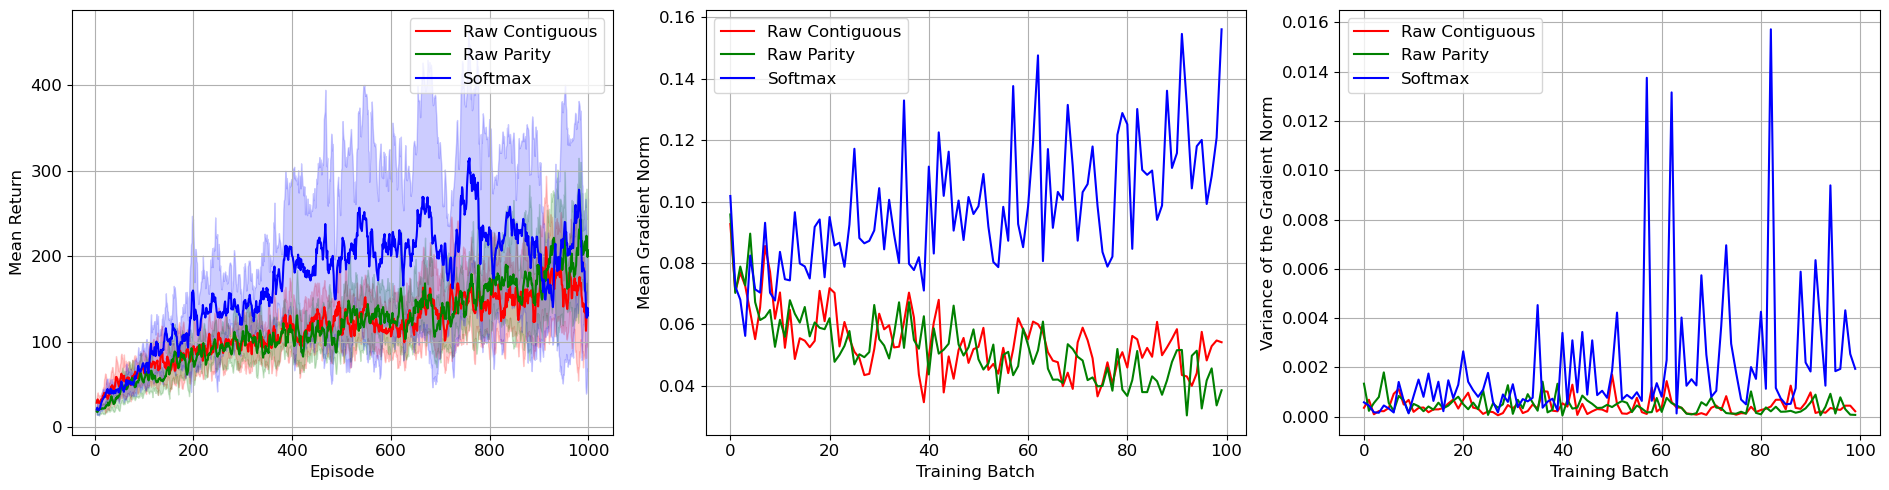

In [102]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5), tight_layout=True)

# Plot rewards
axs[0].plot(jerbi_model_raw_contiguous_rewards_mean, color="red", label="Raw Contiguous")
axs[0].plot(jerbi_model_raw_parity_rewards_mean, color="green", label="Raw Parity")
axs[0].plot(jerbi_model_softmax_rewards_mean, color="blue", label="Softmax")
axs[0].fill_between(np.arange(len(jerbi_model_raw_contiguous_rewards_mean)), 
                    np.clip(jerbi_model_raw_contiguous_rewards_mean - jerbi_model_raw_contiguous_rewards_std, a_min=0, a_max=500),
                    np.clip(jerbi_model_raw_contiguous_rewards_mean + jerbi_model_raw_contiguous_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(jerbi_model_raw_parity_rewards_mean)), 
                    np.clip(jerbi_model_raw_parity_rewards_mean - jerbi_model_raw_parity_rewards_std, a_min=0, a_max=500),
                    np.clip(jerbi_model_raw_parity_rewards_mean + jerbi_model_raw_parity_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(jerbi_model_softmax_rewards_mean)), 
                    np.clip(jerbi_model_softmax_rewards_mean - jerbi_model_softmax_rewards_std, a_min=0, a_max=500),
                    np.clip(jerbi_model_softmax_rewards_mean + jerbi_model_softmax_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="blue")
axs[0].set_xlabel("Episode", fontsize=12)
axs[0].set_ylabel("Mean Return", fontsize=12)
axs[0].legend(fontsize=12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot mean gradient norm
axs[1].plot(jerbi_model_raw_contiguous_norm_grads[1], color="red", label="Raw Contiguous")
axs[1].plot(jerbi_model_raw_parity_norm_grads[1], color="green", label="Raw Parity")
axs[1].plot(jerbi_model_softmax_norm_grads[1], color="blue", label="Softmax")
axs[1].set_xlabel("Training Batch", fontsize=12)
axs[1].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

# Plot variance of gradient norm
axs[2].plot(jerbi_model_raw_contiguous_variance_grads[1], color="red", label="Raw Contiguous")
axs[2].plot(jerbi_model_raw_parity_variance_grads[1], color="green", label="Raw Parity")
axs[2].plot(jerbi_model_softmax_variance_grads[1], color="blue", label="Softmax")
axs[2].set_xlabel("Training Batch", fontsize=12)
axs[2].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[2].legend(fontsize=12)
axs[2].xaxis.set_tick_params(labelsize=12)
axs[2].yaxis.set_tick_params(labelsize=12)
axs[2].grid(True)

plt.show()

